# Quick Tutuorial for $\sigma$-Calibration in Gaussian $\sigma$-CVAE

In this notebook, we introduce $\sigma$-calibration, a technique to improve the model's ability to accurately approximate the target distribution. $\sigma$-calibration only applies to $\sigma$-CVAE, where the decoder variance $\sigma$ is a non-fixed model parameter. It incorporates a data-driven mechanism to refine and regulate $\sigma$ during training, addressing challenges such as posterior collapse and instable variance estimation. 

The data-driven mechanism requires monitoring the Kullback-Leibler Divergence (KLD) component of the Evidence Lower Bound (ELBO), 
and $\sigma$-calibration ensures that the decoder's output variance is appropriately tuned at convergence. Unlike conventional approaches that use a fixed or pre-determined decoder variance, this method avoids the reliance on hyperparameters, such as $\beta$-VAE frameworks, thereby enhancing both the flexibility and robustness of the CVAE model in capturing complex conditional distributions. 


In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

# Twomoon dataset
from data import twomoon

# logistics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
rng = np.random.default_rng(seed=1)
torch.manual_seed(1)
np.random.seed(1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1)
print(torch.__version__)

1.8.2+cu111


### Generating training dataset: Two-moon

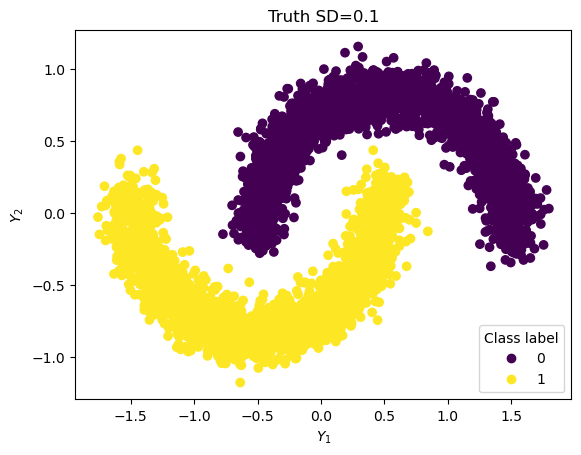

In [2]:
n = 5000
data_x, data_y = twomoon(n,sigma=0.1)  # true latent size  = 2
data_x = torch.from_numpy(data_x).type(torch.FloatTensor)  # float32
data_y = torch.from_numpy(data_y).type(torch.FloatTensor)
scatter  = plt.scatter(data_y[:,0],data_y[:,1],c=data_x[:,0].reshape(-1).detach().numpy(),label = data_x[:,0].reshape(-1).detach().numpy())
plt.xlabel("$Y_1$")
plt.ylabel("$Y_2$")
plt.legend(*scatter.legend_elements(),loc ="lower right",title = "Class label") 
plt.title("Truth SD=0.1")
#plt.savefig("Truth SD=0.1.pdf")
plt.show()


### A CVAE model with only $\theta,\phi$

Here, we define the CVAE model without sigma, making it easier to understand how $\sigma$ is manually updated in later codes.

In [3]:
class Encoder(nn.Module):
    def __init__(self, layer_sizes, latent_size,activation= "Tanh"):  # layer_sizes=[px, h1, ..., hl]
        super().__init__()
        if activation == "ReLU":
            act_func =  nn.ReLU()
        if activation == "Tanh":
            act_func =  nn.Tanh()
        if activation == "Sigmoid":
            act_func =  nn.Sigmoid()
        if activation == "LeakyReLU":
            act_func =  nn.LeakyReLU(0.1)
        self.MLP = nn.Sequential()  # [px+py, h1, ..., hl]
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=act_func)          
        self.linear_mean = nn.Linear(layer_sizes[-1], latent_size)  # [hl, pz]
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x, y=None):
        x = torch.cat((x, y), dim=-1)
        x = self.MLP(x)
        mean = self.linear_mean(x)
        log_var = self.linear_log_var(x)
        return mean, log_var  # [batch_size, pz]

""" MLP mu(y|x,z) """
class Decoder(nn.Module):
    def __init__(self, layer_sizes, input_size,activation= "Tanh"):  # layer_sizes=[hl, ..., h1, (px+py)*nrep]
        super().__init__()
        if activation == "ReLU":
            act_func =  nn.ReLU()
        if activation == "Tanh":
            act_func =  nn.Tanh()
        if activation == "Sigmoid":
            act_func =  nn.Sigmoid()
        if activation == "LeakyReLU":
            act_func =  nn.LeakyReLU(0.1)
        self.MLP = nn.Sequential()  #
        input_size = input_size
        for i, (in_size, out_size) in enumerate(zip([input_size] + layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=act_func)
            self.linear = nn.Linear(out_size, out_size)
    def forward(self, z,x):
        z = torch.cat((z, x), dim=-1)
        u = self.MLP(z)
        u = self.linear(u)
        return u

class CVAE(nn.Module):
    def __init__(self, encoder_layer_sizes, latent_size, px, py, decoder_layer_sizes,args=None):
        super().__init__()
        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list
        self.latent_size = latent_size
        self.px = px
        self.py = py
        self.encoder = Encoder(encoder_layer_sizes, latent_size)
        self.decoder = Decoder(decoder_layer_sizes,input_size=latent_size+px)
        #self.gamma =  torch.nn.Parameter(torch.full((1,), 0)[0], requires_grad=args.model == 'sigma_vae')
        
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    
    def forward(self, x, y):
        mean, log_var = self.encoder(x, y)  # [batch_size, latent_size]
        z = self.reparameterize(mean, log_var)  # [batch_size, nrep] 
        recon = self.decoder(z,x)  
        return recon, mean, log_var #mu_y, mu_z, log_sigma_z
    
    def validate(self,pred_y_mean,x,gamma):
        pred_y_mean = pred_y_mean.detach().cpu().numpy()
        noise = gamma* rng.normal(0, 1, (n,2)) 
        pred_y = pred_y_mean + noise
        x= x.detach().cpu().numpy()
        scatter = plt.scatter(pred_y[:,0],pred_y[:,1],c=x)
        plt.xlabel("$Y_1$")
        plt.ylabel("$Y_2$")
        plt.legend(*scatter.legend_elements(),loc ="lower right",title = "Class label") 
        #plt.title("Reconstructed training data")
        #plt.savefig("Reconstructed training data.pdf")
        plt.show()
        return 
    def test(self,gamma):
        n = 5000
        origin_x = (np.arange(n)>n/2)
        test_x1 = origin_x.reshape(n,1)
        test_x2 = 1 - test_x1
        test_x = np.concatenate((test_x1, test_x2), axis=1)# [2350,]
        z = rng.normal(0,1,(n,2))  
        test_x = torch.from_numpy(test_x).type(torch.FloatTensor)
        z = torch.from_numpy(z).type(torch.FloatTensor)
        test_x = test_x.to(device)
        z = z.to(device)
        sampled_y = vae.decoder(z,test_x).detach().cpu().numpy()
        noise = gamma* rng.normal(0,1,(n,2))  
        sampled_y = sampled_y + noise
        scatter  = plt.scatter(sampled_y[:,0],sampled_y[:,1],c=origin_x)
        plt.xlabel("$Y_1$")
        plt.ylabel("$Y_2$")
        plt.legend(*scatter.legend_elements(),loc ="lower right",title = "Class label") 
        #plt.title("Test sample generated ")
        #plt.savefig("Test sample generated.pdf")
        plt.show()
        return 
        return
    
criterion = nn.GaussianNLLLoss(reduction='sum',full=True)
criterion2 = nn.MSELoss(reduction="sum")
# Lower bound for maximum likelihood
 
def loss_fn(recon_y, y, mean, log_var,gamma): 
    #Computing the loss and its gradient theta and phi
    var = gamma**2 * torch.ones(len(y),device = y.device) # here gamma is the sigma
    NLK = criterion(recon_y, y,var)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    SSE = criterion2(recon_y,y)/y.shape[1] #
    return [NLK + KLD, SSE,KLD]

In [4]:
batch_size = n
K = 25
learning_rate = 0.005
latent_size = 2 
px = data_x.shape[-1]
py = data_y.shape[-1]

### Training module enabling $\sigma$-calibration

In [5]:
def run_experiment(initialization=1, K=25, batch_size= 200, tolerance=0.05,fixed=False,calibration=True):
    """Training module without maximum epoch"""
    vae = CVAE(encoder_layer_sizes=[px+py, 64, 256,64], latent_size=latent_size, px=px, py=py,
        decoder_layer_sizes=[64,256,128,py])
    optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    gamma =initialization # modify to change the initalization of $\sigma$
    MSE = 0
    gamma_list= []
    batch_size = batch_size
    x_ind = np.arange(n)
    gamma_list.append(gamma)
    pertur_index = [0]
    loss_list =[0]
    KLD_list =[0]
    start = time.perf_counter()
    while True:
        for epoch in range(K):
            np.random.shuffle(x_ind)
            vae = vae.to(device)
            train_loss = 0
            train_SSE = 0
            train_KL = 0
            for i in range(0, n, batch_size):
                batch_id = x_ind[i:(i + batch_size)]
                x = data_x[batch_id, :].to(device)
                y = data_y[batch_id, :].to(device)  
                #print(x.shape)
                #print(y.shape)
                optimizer.zero_grad()
                pred_y,mean, log_var = vae(x, y)  
                loss,SSE,KL = loss_fn(pred_y, y, mean, log_var,gamma) 
                loss.backward()
                train_loss += loss.item()
                train_SSE += SSE.item()
                train_KL += KL.item()
                optimizer.step()
            loss_list.append(train_loss/n)
            KLD_list.append(train_KL/n)
        #print("Epoch {:02d}/{:02d}, Sigma{:9.4f} Loss(ELBO) {:9.4f}, MSE {:9.4f},KLD {:9.4f},"
        #      .format(epoch+1, K, gamma, train_loss/n,train_SSE/n, train_KL/n))
        #vae.validate(pred_y,data_x[x_ind,0],gamma)
        #print('---------------------------')
        #vae.test(gamma)
        if fixed == False: # sigma to be learned or not
            if calibration == True: # sigma to be calibrated or not
                perturbation_var= 1
                if np.abs(loss_list[-1]-loss_list[-K-1])>0.001: # ELBO convergence critierion
                    gamma= np.sqrt(train_SSE/n)  # update $\sigma$ with calibration 
                    gamma_list.append(gamma)
                    pertur_index.append(0)
                else:
                    if int(train_KL/n <tolerance): # calibration criterion
                        print("Vanishing KLD detected")
                        gamma = np.sqrt(train_SSE/n)*np.abs(1+0.5*rng.normal(0,perturbation_var)) # sigma calibration 
                        perturbation_var+=1
                        gamma_list.append(gamma) 
                        pertur_index.append(1)
                    else: 
                        print("final gamma is "+str(gamma))
                        break
            elif calibration == False: 
                if np.abs(loss_list[-1]-loss_list[-K-1])>0.001:
                    gamma= np.sqrt(train_SSE/n) # update $\sigma$ without calibration 
                    gamma_list.append(gamma)
                    pertur_index.append(0)
                else:  
                    print("final gamma is "+str(gamma))
                    break
        else:
            if np.abs(loss_list[-1]-loss_list[-K-1])<0.001: # ELBO convergence critierion
                break
    end = time.perf_counter()
    return gamma_list,loss_list, KLD_list, pertur_index,end-start

In [27]:
def run_experiment(initialization=11, K=250, batch_size = 200, tolerance=0.05,fixed=True,calibration=True,max_iter = 1000):
    """Training module with maximum epoch"""
    vae = CVAE(encoder_layer_sizes=[px+py, 64, 256,64], latent_size=latent_size, px=px, py=py,
        decoder_layer_sizes=[64,256,128,py])
    optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    gamma =initialization
    MSE = 0
    gamma_list= []
    batch_size = batch_size
    x_ind = np.arange(n)
    pertur_index = [0]
    loss_list =[0]
    KLD_list =[0]
    start = time.perf_counter()
    cur_iter = 0
    while cur_iter <= max_iter:
        for epoch in range(K):
            np.random.shuffle(x_ind)
            vae = vae.to(device)
            train_loss = 0
            train_SSE = 0
            train_KL = 0
            for i in range(0, n, batch_size):
                batch_id = x_ind[i:(i + batch_size)]
                x = data_x[batch_id, :].to(device)
                y = data_y[batch_id, :].to(device)  
                #print(x.shape)
                #print(y.shape)
                optimizer.zero_grad()
                pred_y,mean, log_var = vae(x, y)  
                loss,SSE,KL = loss_fn(pred_y, y, mean, log_var,gamma) 
                loss.backward()
                train_loss += loss.item()
                train_SSE += SSE.item()
                train_KL += KL.item()
                optimizer.step()
            loss_list.append(train_loss/n)
            KLD_list.append(train_KL/n)
            gamma_list.append(gamma)
            pertur_index.append(0)
        #print("Epoch {:02d}/{:02d}, Sigma{:9.4f} Loss(ELBO) {:9.4f}, MSE {:9.4f},KLD {:9.4f},"
        #      .format(epoch+1, K, gamma, train_loss/n,train_SSE/n, train_KL/n))
        #vae.validate(pred_y,data_x[x_ind,0],gamma)
        #print('---------------------------')
        #vae.test(gamma)
        if fixed == False:
            if calibration == True:
                perturbation_var= 1
                if np.abs(loss_list[-1]-loss_list[-K+1])>0.001:
                    gamma= np.sqrt(train_SSE/n)
                    gamma_list.append(gamma)
                    pertur_index.append(0)
                else:
                    if int(train_KL/n <tolerance):
                        print("Vanishing KLD detected")
                        gamma = np.sqrt(train_SSE/n)*np.abs(1+0.5*rng.normal(0,perturbation_var))
                        perturbation_var+=1
                        gamma_list.append(gamma)
                        pertur_index.append(1)
                    else: 
                        print("final gamma is "+str(gamma))
                        break
            elif calibration == False:
                if np.abs(loss_list[-1]-loss_list[-K+1])>0.001:
                    gamma= np.sqrt(train_SSE/n)
                    gamma_list.append(gamma)
                    pertur_index.append(0)
                else:  
                    print("final gamma is "+str(gamma))
                    break
        else:
            if np.abs(loss_list[-1]-loss_list[-K+1])<0.001:
                break
        cur_iter +=1
    end = time.perf_counter()
    return gamma_list,loss_list, KLD_list, pertur_index,end-start

### Run experiments without $\sigma$-calibration

Scripts to run experiement on various setting of $K$ without calibration. It demonstrate how easily the learned $\sigma$ deviates from the true. It takes some time to run.

If you prefer not to wait, the results have already been computed and saved in `save.pkl`

In [ ]:
K_list = [1,5,25,50,100,500,2500] # hyperparameter list

gamma_lists = []
loss_lists =[]
KLD_lists = []
pertur_indexs = []
runtimes = []
for k in K_list:
    print("K= "+str(k)+" starts")
    gamma_list,loss_list,KLD_list, pertur_index,runtime = run_experiment(1, k, 5000,0.05,fixed=False,calibration=False)
    if np.abs(gamma_list[-1] -0.1) <0.02:
        print("Recovery of true sigma at K="+str(K)+" succeed, final sigma is "+ str(gamma_list[-1]))
    gamma_lists.append(gamma_list)
    loss_lists.append(loss_list)
    KLD_lists.append(KLD_list)
    pertur_indexs.append(pertur_index)
    runtimes.append(runtime)
print("Experiment completed")

In [6]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp: 
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as inp:
        return pickle.load(inp)        

"""If you run it yourself, uncomment this"""
#obj = [gamma_lists,KLD_lists,pertur_indexs,runtimes]
#save_object(obj, 'save.pkl')
gamma_lists,KLD_lists,pertur_indexs,runtimes = load_object('save.pkl')

Generate the plot for sigma records and walltime to convergence

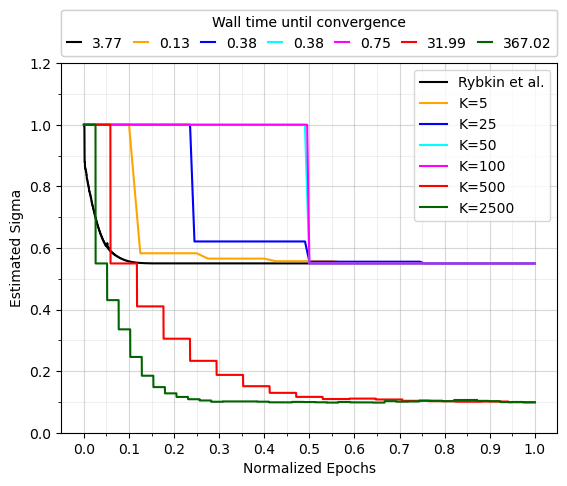

In [7]:
fig, ax = plt.subplots()

colors = ["black","orange","blue","cyan","magenta","red","darkgreen"]
labels = ["Rybkin et al.","K=5","K=25","K=50","K=100","K=500","K=2500"]
for i in range(len(colors)):
    x_normalized = np.linspace(0, 1, len(gamma_lists[i]))
    ax.plot(x_normalized, gamma_lists[i], label=labels[i], color = colors[i])


plt.xlabel("Normalized Epochs")
plt.ylabel("Estimated Sigma")

leg1 = ax.legend()

old_handles, old_labels = ax.get_legend_handles_labels()
new_labels= runtimes

leg2 = ax.legend(handles=old_handles, labels = [np.round(x,2) for x in runtimes], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=7, handlelength=1, title="Wall time until convergence")
ax.add_artist(leg1)
ax.add_artist(leg2)

# Major ticks every 20, minor ticks every 5
x_major_ticks = np.linspace(0, 1, 11)
x_minor_ticks = np.linspace(0, 1, 21)
y_major_ticks = np.arange(0, 1.3, 0.2)
y_minor_ticks = np.arange(0, 1.3, 0.1)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.savefig('withouttrub.pdf',bbox_inches='tight')

### Experiments with the proposed $\sigma$-calibration

Run the following code to observe how σ-calibration successfully recover to true $\sigma$ with significant less wall time to convergence. 

Feel free to modify tolerance $C$, $K$, batch_size or intialization. Repeat may needed if there is no posterior collapse. 

If you want to reproduce our plot, the results have already been computed and saved in `save.pkl` and skip below to generate the plot directly.

In [14]:
K_list = [25] 
for k in K_list:
    print("K= "+str(k)+" starts")
    gamma_list,loss_list, KLD_list, pertur_index,runtime = run_experiment(1, k, 5000,0.05,False,True)
    print("K= "+str(k)+" completed, final sigma learned is "+str(gamma_list[-1]))

# Replace or append the result based on whether the experiment without calibration was skipped.
if len(gamma_lists) == 8:
    gamma_lists[-1] = gamma_list
    KLD_lists[-1] = KLD_list
    pertur_indexs[-1] = pertur_index
    runtimes[-1] = runtime
else:
    gamma_lists.append(gamma_list)
    KLD_lists.append(KLD_list)
    pertur_indexs.append(pertur_index)
    runtimes.append(runtime)

K= 25 starts
Vanishing KLD detected
Vanishing KLD detected
final gamma is 0.10190301615225987
K= 25 completed, final sigma learned is 0.10190301615225987


In [ ]:
# Save the result to the lists of results.
obj = [gamma_lists,KLD_lists,pertur_indexs,runtimes]
save_object(obj, 'your_own_save.pkl')
gamma_lists,KLD_lists,pertur_indexs,runtimes = load_object('your_own_save.pkl')

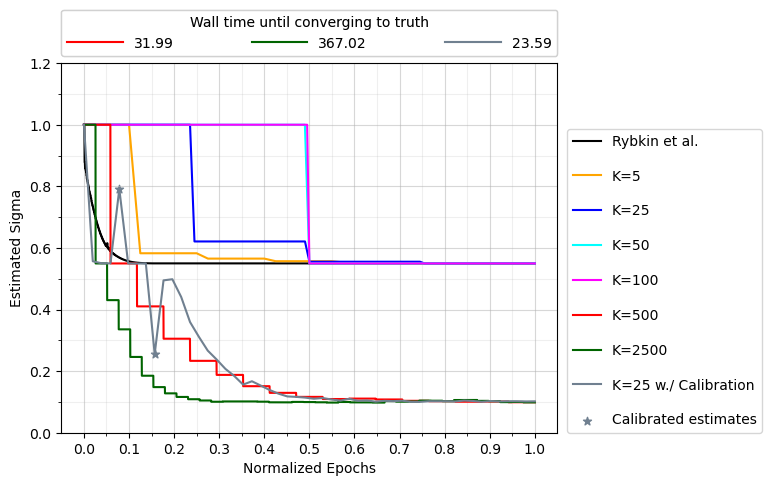

In [15]:
fig, ax = plt.subplots()

# plot old ones
colors = ["black","orange","blue","cyan","magenta","red","darkgreen"]
labels = ["Rybkin et al.","K=5","K=25","K=50","K=100","K=500","K=2500"]
for i in range(len(colors)):
    x_normalized = np.linspace(0, 1, len(gamma_lists[i]))
    ax.plot(x_normalized, gamma_lists[i], label=labels[i], color = colors[i])
    pertur_index= pertur_indexs[-1]

# plot the trajectory of $\sigma$-calibration
x_normalized = np.linspace(0, 1, len(gamma_lists[-1]))
x = [val for i, val in enumerate(x_normalized) if pertur_index[i]]
y = [val for i, val in enumerate(gamma_lists[-1]) if pertur_index[i]]
ax.scatter(x,y,marker="*",label= "Calibrated estimates",color ="slategray")
ax.plot(x_normalized, gamma_lists[-1], label="K=25 w./ Calibration", color = "slategray")

plt.xlabel("Normalized Epochs")
plt.ylabel("Estimated Sigma")

leg1 = ax.legend(bbox_to_anchor=(1.02, 0,2.04,1), labelspacing=1.5,loc="lower left", borderaxespad=0)

old_handles, old_labels = ax.get_legend_handles_labels()
new_labels= runtimes

# a modified legend
leg2 = ax.legend(handles=old_handles[5:8], labels = [np.round(x,2) for x in runtimes[5:8]], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3, handlelength=4, title="Wall time until converging to truth")
ax.add_artist(leg1)
ax.add_artist(leg2)

# Major ticks every 20, minor ticks every 5
x_major_ticks = np.linspace(0, 1, 11)
x_minor_ticks = np.linspace(0, 1, 21)
y_major_ticks = np.arange(0, 1.3, 0.2)
y_minor_ticks = np.arange(0, 1.3, 0.1)

ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)
ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
plt.savefig('withtrub.pdf',bbox_inches='tight')

At last, we provide some useful codes for reproducing our results in the paper.


* looping the run_experiment function, used for ablation section in Appendix.

In [ ]:
# different initialization of $\sigma$
%%capture
repeat_experiement = 20
initialization = np.linspace(0.05,1,20)
final_gamma = np.empty((20,repeat_experiement))
average_ELBO = np.empty((20,repeat_experiement))
average_KL = np.empty((20,repeat_experiement))
for i in range(20):
    for j in range(repeat_experiement):
        final_gamma[i,j],average_ELBO[i,j],average_KL[i,j] = run_experiment(initialization=initialization[i], 25, 5000,tolerance=0.25,fixed=False)

SE= (final_gamma-0.1)**2
mse = SE.mean(1)
average_ELBO.mean(1)
average_KL.mean(1)


* modifying the loss and annealing with $\beta$, used for comparison experiment with KL annealing.

In [ ]:
def loss_fn_with_beta(recon_y, y, mean, log_var,gamma,beta):
    var = gamma**2 * torch.ones(len(y),device = y.device)
    NLK = criterion(recon_y, y,var)
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    beta_vec = beta* torch.ones(1,device= y.device)
    SSE = criterion2(recon_y,y)/y.shape[1] #
    return [NLK + beta_vec*KLD, SSE,KLD]


def monotonic_annealing(num_iter,length):
    #return current beta in monotonic annealing for reweighting KL divergence
    beta = min(2*num_iter/length,1)+1e-6  # avoid using 0 beta
    return beta

def cycle_annealing(num_iter,length,max_cycle):
    #return current beta in cyclic annealing for reweighting KL divergence
    if num_iter > length*max_cycle:
        beta = 1
    else:
        iter_cycle = num_iter % length
        beta = min(2*iter_cycle/length,1)+1e-6  # avoid using 0 beta
    return beta

# delete $\sigma$-calibration module in the run_experiment function, and include kl_annealing module
# remember to keep the learned $\sigma$ module. It should look like as below
def run_experiment(initialization=1, K=250, fixed=True, kl_annealing = "cycle"):
while True:
        num_iter += 1
        if kl_annealing == "cycle":
            beta = cycle_annealing(num_iter,length=10,max_cycle=5)
        if kl_annealing == "mono":
            beta = monotonic_annealing(num_iter,length=50)